# Задача и используемые подходы

Распознать сообщения, закодированные в аудиофайлах при помощи кода Морзе.
Формат: .opus, 8 кГц, сообщения включают кириллицу, латиницу, цифры и пробелы.
Метрика: среднее расстояние Левенштейна (Levenshtein Mean) между расшифрованным и эталонным текстом.

ample_submission.csv – пример отправки в систему оценки

train.csv – обучающие примеры и расшифровки к ним

test.csv – тестовый список файлов для оценки, совпадает со списком в sample_submission.csv

morse_dataset.zip – zip-файл, содержащий аудиофайлы в формате opus, полученные из исходников с частотой дискретизации 8кГц

logbook.txt – журнал обмена сообщениями колонии

## Подход №1: Алгоритмический подход (бинарная маска)
**Идея**

Попробовать ручную декодировку сигналов Морзе из аудио:

Извлечь энергетическую кривую из аудиосигнала;

Построить бинарную маску (0 — тишина, 1 — сигнал) с помощью порога по амплитуде или энергии;

По длине участков 1 и 0 интерпретировать:

короткие 1 как . (точка);

длинные 1 как - (тире);

короткие 0 как паузы между символами;

длинные 0 как пробелы между словами.

**Реализация**

Использовал librosa для извлечения амплитудной огибающей или мел-энергии;

Устанавливал фиксированный или адаптивный порог;

Проводил постобработку для сглаживания шумов и артефактов.

**Почему не сработало?**

Несмотря на простоту идеи, подход оказался крайне чувствительным к шуму и нерегулярностям в реальных записях:

Варьируемая громкость и затухание в конце сигнала мешали стабильно выделять точки/тире;

Сложность в калибровке порога: один порог не подходил ко всем записям;

Паузы в реальных аудио часто были нечётко разделены — маска путалась, где символ, а где пробел;

**Итог**

Подход был хорош как proof-of-concept, но не дал приемлемых результатов 



## Подход №2: CNN + RNN + CTC
**Идея**

Построить универсальную архитектуру, способную автоматически выучить шаблоны Морзе-сигналов без необходимости явного выделения сигналов или порогов.
Пайплайн выглядел так:

Преобразовать аудио в мел-спектрограмму;

Подать спектрограмму в Conv1D + BiGRU;

Использовать CTC Loss для обучения на последовательности символов ['.', '-', ' ', '|'].

**Архитектура**

*CNN* (три уровня) для извлечения временно-частотных признаков;

*BiGRU* для моделирования зависимости между элементами;

*LayerNorm + Linear* — классификатор;

*CTCLoss* для обучения без выравнивания.

**Почему не сработало?**

Несмотря на логичность подхода и популярность в задачах ASR, модель не достигла стабильной сходимости. Возможные причины:

Спектрограммы — слишком шумный вход: паузы, щелчки, эхо мешают извлечению четких паттернов точка/тире;

Входная последовательность — избыточно длинная: увеличивает сложность обучения и мешает CTC корректно схлопывать повторяющиеся символы;

Проблемы с декодированием: предсказания были нестабильны, много blank, сложнее отфильтровывать повторы.

**Итог**

Метрика Левенштейна была около 8.5

## Финальный подход

**Идея**

Вместо прямого применения предобученных моделей ASR (как Wav2Vec2), я использовал облегченный подход:

Анализирую аудиосигнал как одномерную временную последовательность по доминирующей частоте (из мел-спектрограммы).

Обучаем собственную модель (CNN + BiGRU) для декодирования последовательности в коды Морзе: точки (.), тире (-), пробел ( ), разделитель слов (|).

Далее применяем простой декодер Морзе для получения финального текста на кириллице/латинице.



**Архитектура модели**

class MorseNet(nn.Module):
    Conv1D ➜ Conv1D ➜ Conv1D ➜ MaxPool ➜ BiGRU ➜ Linear ➜ CTC Loss

Вход: [batch, time, 1] — временной ряд

CNN блоки: захватывают локальные паттерны

BiGRU: улавливает зависимости во времени

CTC Loss: позволяет распознавать последовательности произвольной длины



**Обучение**

Loss: nn.CTCLoss(blank=4) — учитывая 4 класса (., -, ' ', |)

Оптимизатор: Adam (lr=1e-4)

Batch size: 64

Эпохи: до 40

**Постобработка предсказаний**

Полученная последовательность меток очищается от повторений и blank символов.

Декодируется в строку из точек и тире.

Применяется словарь MORSE_REVERSE_DICT, чтобы перевести код Морзе в текст.



# Решение

## Импроты

In [1]:
import numpy as np
import pandas as pd
import torch
import librosa
from torch import nn
from torch.nn import CTCLoss
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch.nn.functional as F
from tqdm import tqdm
from collections import Counter
from Levenshtein import distance as levenshtein_distance
import ast

# Предпросмотр данных

In [2]:
SAMPLING_RATE = 22050
AUDIO_DIR = "morse_dataset/morse_dataset"

In [3]:
df = pd.read_csv("train.csv")
df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


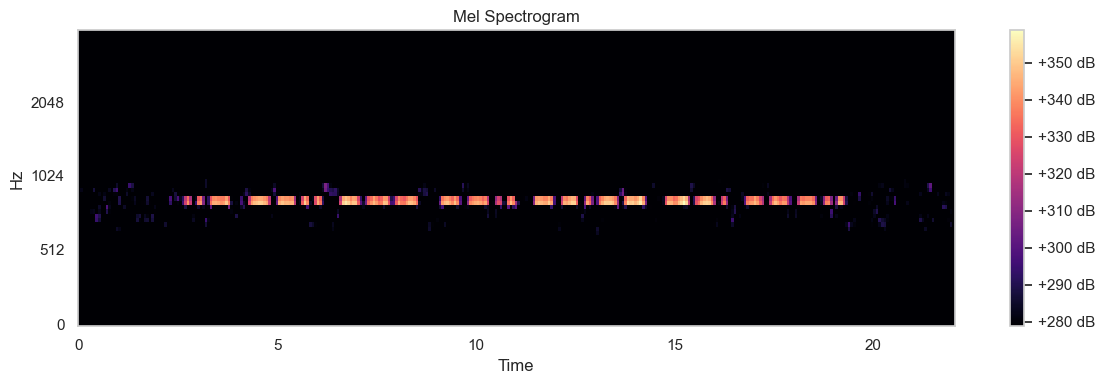

In [7]:
def get_mel_spectrogram(file_path, n_mels=80, SAMPLING_RATE = 22050):
    y, sr = librosa.load(file_path, sr=SAMPLING_RATE, duration=8.0)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, n_fft=2048, hop_length=512, power=13.9)
    mel_spec = librosa.power_to_db(mel_spec)
    return mel_spec

file_path = 'morse_dataset/morse_dataset/7.opus'
signal, sr = librosa.load(file_path, sr=8000)  # 8kHz — как указано в задании

plt.figure(figsize=(12, 4))
librosa.display.specshow(get_mel_spectrogram(file_path),
                         sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [5]:
mel_spec = get_mel_spectrogram(file_path)
mel_spec.shape

(80, 345)

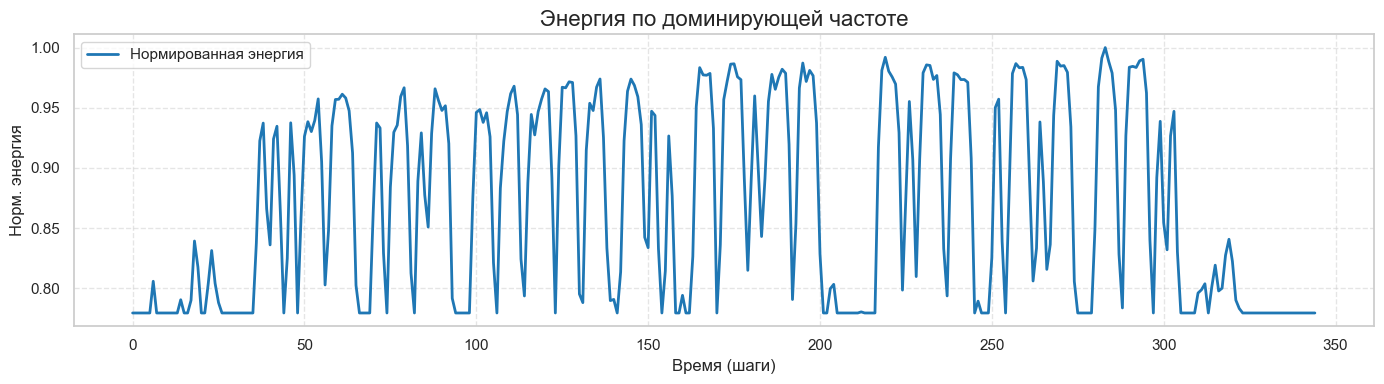

In [6]:
sns.set(style="whitegrid")

most_pwr_frq = mel_spec.mean(axis=1).argmax()
energy = mel_spec[most_pwr_frq]
energy /= np.max(energy)

plt.figure(figsize=(14, 4))
plt.plot(energy, color="#1f77b4", linewidth=2, label="Нормированная энергия")
plt.title("Энергия по доминирующей частоте", fontsize=16)
plt.xlabel("Время (шаги)", fontsize=12)
plt.ylabel("Норм. энергия", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

C:\Users\rusbe\AppData\Local\Temp\ipykernel_31416\1983082620.py:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rusbe\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


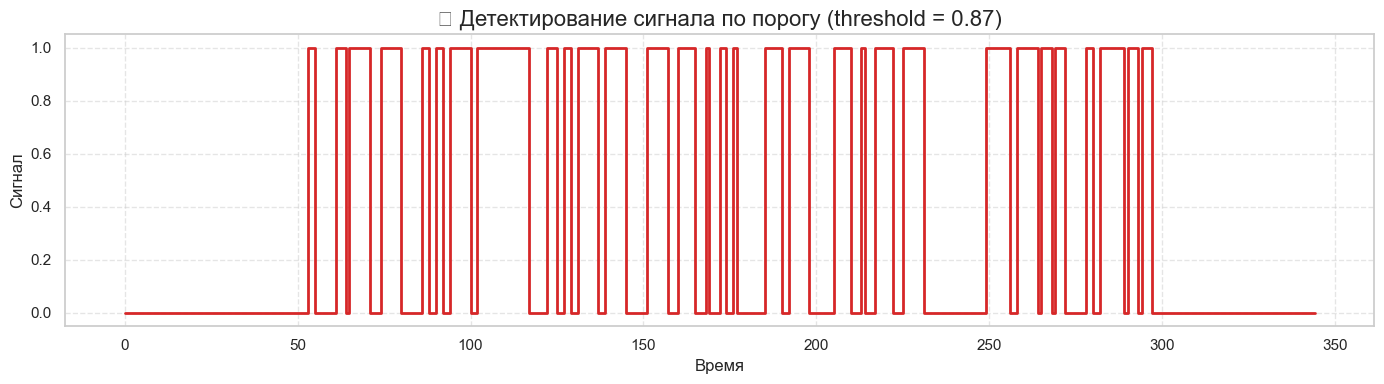

In [59]:
energy = mel_spec.max(axis=0)  # средняя энергия по Mel-осям

energy /= np.max(energy)

threshold = 0.87 # порог

binary_mask = energy > threshold


plt.figure(figsize=(14, 4))
plt.plot(binary_mask.astype(int), color="#d62728", drawstyle="steps-post", linewidth=2)
plt.title("🎯 Детектирование сигнала по порогу (threshold = 0.87)", fontsize=16)
plt.xlabel("Время", fontsize=12)
plt.ylabel("Сигнал", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
MORSE_DICT = {
    ".-": "А", "-...": "Б", ".--": "В", "--.": "Г", "-..": "Д",
    ".": "Е", "...-": "Ж", "--..": "З", "..": "И", ".---": "Й",
    "-.-": "К", ".-..": "Л", "--": "М", "-.": "Н", "---": "О",
    ".--.": "П", ".-.": "Р", "...": "С", "-": "Т", "..-": "У",
    "..-.": "Ф", "....": "Х", "-.-.": "Ц", "---.": "Ч", "----": "Ш",
    "--.-": "Щ", ".--.-.": "Ъ", "-.--": "Ы", "-..-": "Ь", "...-...": "Э", 
    "..--": "Ю", ".-.-": "Я", 
    "-----": "0", ".----": "1", "..---": "2", 
    "...--": "3", "....-": "4", ".....": "5", "-....": "6", "--...": "7", 
    "---..": "8", "----.": "9", "|": " ", "#" : "--.--"
}

In [25]:
def morse_decoder(morse_seq):
    # Пример входа: ".. .-   .-.. ---"
    decoded_text = ""
    words = morse_seq.strip().split("|")  # разделение слов
    for word in words:
        letters = word.strip().split(" ")
        for letter in letters:
            decoded_text += MORSE_DICT.get(letter, "?")
        decoded_text += " "
    return decoded_text.strip()

In [26]:
# Извлечение Морзе-последовательности из аудио
def extract_morse(path):
    mel_spec = get_mel_spectrogram(path)
    
    most_pwr_frq = mel_spec.mean(axis=1).argmax()
    energy = mel_spec[most_pwr_frq]

    energy /= np.max(energy)

    return energy

In [27]:
symbols = Counter()
for message in df['message']:
    symbols.update(Counter(message))

In [28]:
symbol_df = pd.DataFrame(symbols.items(), columns=['symbol', 'count'])

symbol_df = symbol_df.sort_values(by='count', ascending=False)
symbol_df

,symbol,count
32,,13618
11,Т,6428
39,Е,6377
7,И,6200
31,М,6181
15,А,6138
13,С,6132
21,Я,6079
22,Н,6072
19,Б,6068


In [29]:
len(symbol_df['symbol'])

44

# Нейросетевой подход

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [31]:
MORSE_DICT = {v: k for k, v in MORSE_DICT.items()}
CHAR2IDX = {'.': 0, '-': 1, ' ': 2, '|': 3}

In [32]:
def text_to_morse(text):
    return ' '.join([MORSE_DICT.get(c, '') for c in text.upper() if c in MORSE_DICT])

In [33]:
def text_to_morse_labels(text):
    seq = []
    for idx, char in enumerate(text.upper()):
        morse = MORSE_DICT.get(char, '')
        for symbol in morse:
            seq.append(CHAR2IDX[symbol])
        seq.append(CHAR2IDX[' '])
    if seq:
        while seq and seq[-1] == CHAR2IDX[' ']:
            seq.pop()
    return seq

In [34]:
text_to_morse("32Ю7МЫ# ЗЛ")

'...-- ..--- ..-- --... -- -.-- | --.. .-..'

In [71]:
text_to_morse_labels("32Ю7МЫ ЗЛ")

[0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0]

In [50]:
train_df = pd.read_csv("train.csv")
morse_seq_col = []
morse_text_col = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    filename = row['id']
    text = row['message']
    path = os.path.join(AUDIO_DIR, filename)

    morse_seq = extract_morse(path)
    morse_text = text_to_morse_labels(text)

    morse_seq_col.append(morse_seq)
    morse_text_col.append(morse_text)

train_df['morse_seq'] = morse_seq_col
train_df['morse_text'] = morse_text_col

train_df.to_csv('preprocessed_data.csv', index=False)

  0%|          | 0/30000 [00:00<?, ?it/s]c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:2944: RuntimeWarning: overflow encountered in power
  np.abs(
100%|██████████| 30000/30000 [21:55<00:00, 22.80it/s]


In [ ]:
x=pd.read_csv('preprocessed_data.csv')

False

In [73]:
class MorseDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.df.dropna(subset=["morse_seq", "morse_text"], inplace=True)
        self.data = []
        for _, row in self.df.iterrows():
            seq = np.array(row['morse_seq'].strip("[]").split(), dtype=np.float32)
            target = np.array(ast.literal_eval(row['morse_text']), dtype=np.int64)
            self.data.append((seq, target))
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, target = self.data[idx]
        return torch.tensor(seq), torch.tensor(target)

def collate_fn(batch):
    inputs, targets = zip(*batch)
    input_lengths = [len(x) for x in inputs]
    target_lengths = [len(y) for y in targets]
    
    inputs_padded = nn.utils.rnn.pad_sequence(inputs, batch_first=True).unsqueeze(-1)  # (B, T, 1)
    targets_concat = torch.cat(targets)  # CTC требует конкатенированные таргеты

    return inputs_padded, targets_concat, input_lengths, target_lengths


In [74]:
# === Model ===
class MorseNet(nn.Module):
    def __init__(self, input_channels=1, conv_channels=128, rnn_hidden=256, num_classes=4):
        super(MorseNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, conv_channels, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(conv_channels, conv_channels, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(conv_channels, conv_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
        )

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)

        self.birnn = nn.GRU(
            input_size=conv_channels,
            hidden_size=rnn_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.15
        )

        self.norm = nn.LayerNorm(rnn_hidden * 2)

        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes + 1)  # +1 for CTC blank
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.birnn(x)
        x = self.norm(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
# === Обучение ===
model = MorseNet().to(device)
criterion = nn.CTCLoss(blank=4, reduction="mean", zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

dataset = MorseDataset("preprocessed_data.csv")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

for epoch in range(40):
    model.train()
    total_loss = 0
    for x_batch, y_batch, x_lens, y_lens in tqdm(dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        outputs = outputs.permute(1, 0, 2)  # for CTC

        loss = criterion(outputs, y_batch, x_lens, y_lens)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")

In [ ]:
torch.save(model.state_dict(), 'model_msfq.pth')

In [25]:
IDX2CHAR = {0: '.', 1: '-', 2: ' ', 3: '|'}
def decode_idx_sequence(seq, idx2char):
    return ''.join([idx2char[i] for i in seq])

In [ ]:
def process_dataframe(df, audio_folder):
    preds = []
    dists = []

    for _, row in df.iterrows():
        filename = row['id']
        true_text = row['message']

        path = os.path.join(audio_folder, filename)
        try:
            morse_seq = extract_morse(path)
            input_tensor = torch.tensor(morse_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # [B, C, T]

            with torch.no_grad():
                output = model(input_tensor)
                pred = torch.argmax(output, dim=-1).squeeze().cpu().tolist() 

            pred_filtered = []
            last = None
            for p in pred:
                if p != last and p != len(IDX2CHAR):
                    pred_filtered.append(p)
                last = p

            pred_morse_seq = decode_idx_sequence(pred_filtered, IDX2CHAR)
            decoded = morse_decoder(pred_morse_seq)

        except Exception as e:
            decoded = "[ERROR]"
            print(f"Ошибка в {filename}: {e}")

        decoded = decoded.replace("###", " ")
        dist = levenshtein_distance(decoded, true_text)
        preds.append(decoded)
        dists.append(dist)

    df['predicted'] = preds
    df['levenshtein'] = dists
    return df

In [ ]:
model = MorseNet().to(device)
model.load_state_dict(torch.load("model_msfq_v3_38ep.pth", map_location=torch.device('cpu')))

In [ ]:
audio_folder = "morse_dataset/morse_dataset"

df = pd.read_csv("preprocessed_data.csv").head(200)
df_result = process_dataframe(df, audio_folder)

In [84]:
df_result[['message', 'predicted', 'levenshtein']]

,message,predicted,levenshtein
0,03ЩУЫЛПИГХ,#,10
1,ЪЛТ0ДС6А3Г,Х,10
2,5ЭКЫБЗХЯН,Х,8
3,ЖЫЦОИ68КФ,5,9
4,32Ю7МЫ ЗЛ,#,9
...,...,...,...
195,КЯЙ7ЫМРТК,5,9
196,ЖБЙВШ9У,И,7
197,9ТЪЬМАЫ90У,Р,10
198,2УМИ84ЗЮ,#,8


In [86]:
df_result['levenshtein'].mean()

8.65

In [87]:
bad_cases = df_result[df_result['levenshtein'] > 10]
print(bad_cases[['message', 'predicted']].sample(5))

           message predicted
87     1БЛТЖЫ МПДМ         #
145    ШК2ННТЧ ЭТТ         #
90     1МБДЗТФПУ7Н         #
113  ЕД2ДЯЬФИЭ ЮВИ         #
140   5ЖК УКМПФЭ А         #


In [ ]:
model.eval()

audio_folder = "morse_dataset/morse_dataset"
sub_df = pd.read_csv("sample_submission.csv")

for idx, row in sub_df.iterrows():
    filename = row['id']
    path = os.path.join(audio_folder, filename)

    try:
        morse_seq = extract_morse(path)
        input_tensor = torch.tensor(morse_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # [B, C, T]

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=-1).squeeze().cpu().tolist() 

        pred_filtered = []
        last = None
        for p in pred:
            if p != last and p != len(IDX2CHAR):
                pred_filtered.append(p)
            last = p

        pred_morse_seq = decode_idx_sequence(pred_filtered, IDX2CHAR)
        decoded = morse_decoder(pred_morse_seq)

    except Exception as e:
        decoded = "[ERROR]"
        print(f"Ошибка в {filename}: {e}")

    sub_df.at[idx, 'message'] = decoded

sub_df.to_csv('submission.csv', index=False)
print("submission file created")

submission file created
